In [16]:
import numpy as np
import glob as gb
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Dropout, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

In [17]:
# Định nghĩa kích thước ảnh đầu vào
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

# Đọc ảnh từ thư mục
TRAIN_PATH = 'dataset/nails_segmentation/images/'
train_ids = gb.glob(TRAIN_PATH + '*.jpg')

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    img = imread(id_)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    X_train[n] = img 

# Chuẩn hóa ảnh về khoảng [0,1]
X_train = X_train.astype("float32") / 255.0

# Đọc nhãn từ thư mục
TRAIN_PATH = 'dataset/nails_segmentation/labels/'
IMG_CHANNELS = 1  # Nhãn là ảnh đơn kênh (grayscale)
train_ids = gb.glob(TRAIN_PATH + '*.jpg')

Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    mask = imread(id_)[:,:,:1] 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    Y_train[n] = mask 

# Chuyển nhãn sang kiểu float32
Y_train = Y_train.astype("float32")

100%|██████████| 52/52 [00:01<00:00, 50.68it/s]


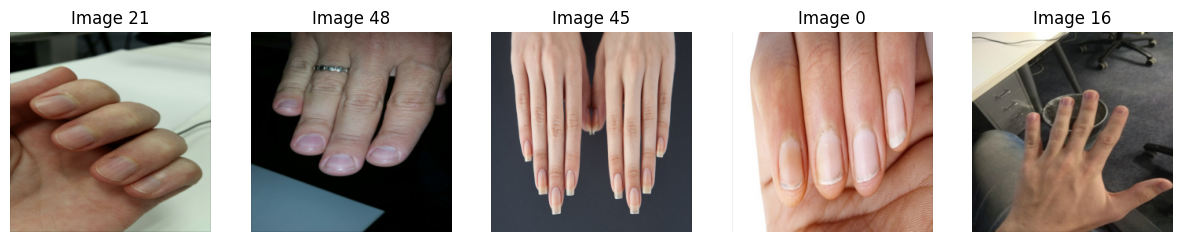

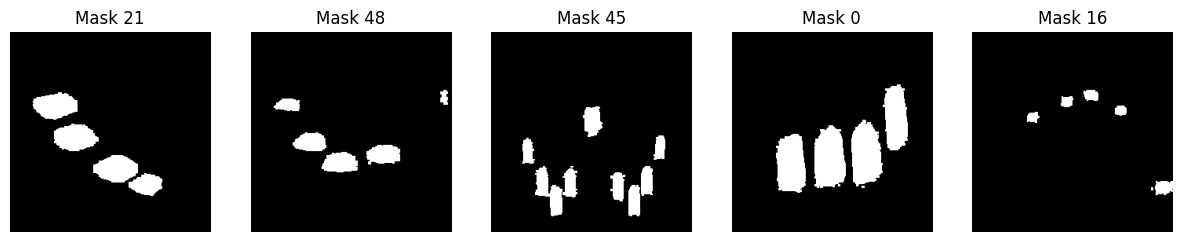

In [18]:
# Chọn 10 chỉ số ngẫu nhiên duy nhất
sample_indices = np.random.randint(0, len(X_train), 5)

# Hiển thị ảnh gốc (X_train)
plt.figure(figsize=(15, 6))
for n, i in enumerate(sample_indices):
    plt.subplot(1, 5, n + 1)  # 2 hàng, 5 cột
    plt.imshow(X_train[i], cmap="gray")  # cmap=None nếu ảnh màu
    plt.axis("off")
    plt.title(f"Image {i}")

plt.show()

# Hiển thị mask (Y_train) tương ứng
plt.figure(figsize=(15, 6))
for n, i in enumerate(sample_indices):
    plt.subplot(1, 5, n + 1)  # 2 hàng, 5 cột
    plt.imshow(Y_train[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Mask {i}")

plt.show()

In [19]:
# Định nghĩa Dice Score và Dice Loss
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)  
    y_pred_f = K.flatten(y_pred)  
    intersection = K.sum(y_true_f * y_pred_f)  
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [22]:
def unet_small(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Downsampling path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)

    # Upsampling path
    u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c2)
    u3 = concatenate([u3, c1])
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u3)
    c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    # Đầu ra có 1 kênh (thay vì 3 kênh)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

# Gọi mô hình với IMG_CHANNELS = 1
model = unet_small(256, 256, 3)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_28[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_30[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 256, 256,  │      8,224 │ conv2d_31[0][0]   │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │     18,464 │ concatenate_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_32[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 256, 256,  │         33 │ conv2d_33[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 101,537 (396.63 KB)

 Trainable params: 101,537 (396.63 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Thiết lập callback
EarlyStop = EarlyStopping(patience=10, restore_best_weights=True)
Reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", verbose=2, factor=0.5, min_lr=0.00001)
model_check = ModelCheckpoint("model.keras", monitor="val_loss", verbose=1, save_best_only=True)

callback = [EarlyStop, Reduce_LR, model_check]

# Huấn luyện mô hình
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.1,
    batch_size=8,
    epochs=50,
    callbacks=callback,
    verbose=1,
    shuffle=True,
)

Epoch 1/50


C:\Users\hung0\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9124 - loss: 0.4360
Epoch 1: val_loss improved from inf to 0.37030, saving model to model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9147 - loss: 0.4287 - val_accuracy: 0.9330 - val_loss: 0.3703 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 903ms/step - accuracy: 0.9388 - loss: 0.3207
Epoch 2: val_loss improved from 0.37030 to 0.32868, saving model to model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 951ms/step - accuracy: 0.9384 - loss: 0.3229 - val_accuracy: 0.9330 - val_loss: 0.3287 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.9403 - loss: 0.3147
Epoch 3: val_loss improved from 0.32868 to 0.32672, saving model to model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 973ms/step - accuracy: 0.9396 - loss: 0.3163 - val_accuracy: 0.9330 - val_loss: 0.3267 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 918ms/step - accuracy: 0.9389 - loss: 0.3080
Epoch 4: val_loss improved 

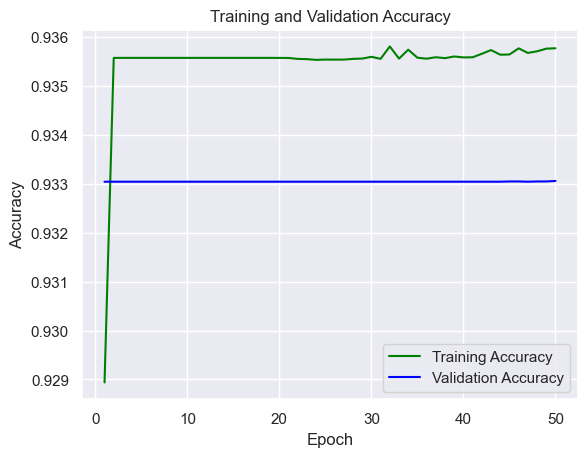

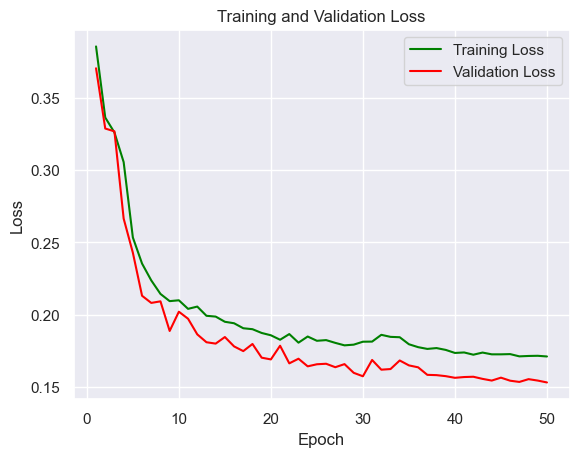

In [24]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Dự đoán trên tập test
y_pred = model.predict(X_train)

# Làm tròn dự đoán về 0 hoặc 1
y_pred = (y_pred > 0.5).astype("float32")

# Lấy loss và accuracy từ history
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

# In kết quả
print(f"Validation Accuracy: {val_acc*100:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

def dice_score(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-7)  # Thêm epsilon để tránh chia cho 0

# Tính Dice Score trung bình trên toàn bộ tập huấn luyện
dice = dice_score(Y_train, y_pred)

# In kết quả
print(f"Dice Score: {dice:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 577ms/step
Validation Accuracy: 93.3057
Validation Loss: 0.1532
Dice Score: 0.9225
